# Train and Compare Machine Learning Models
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import training and test data
* Run many ML algorithms using SageMaker Autopilot
* Run many ML algorithms using H2O AutoML
* Compare all model performance in test dataset
* Choosing and save the best model

# 1. Parameters

In [29]:
#Name
ModelName = 'titanic_propensity_survive'
#Version
ModelVersion = 'v18'

#Model ID
ModelId = ModelName+'_'+ModelVersion

#Setting the model target variable name
VarTarget = 'survived'
VarId = 'passengerid'
VarDate = 'referencedate'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

#Bucket already created on S3
bucket = 'data-science-lab'

CAT = ['pclass'
,'embarked'
,'cabine_prefix'
,'ticket_str'
,'nametitle']

#float
NUM = ['fare'
,'sibsp'
,'parch'
,'age_mean'
,'ticket_int']
selected_features = CAT + NUM

# 2. Import Libraries

In [16]:
import sys
sys.path.append('/var/lang/lib/python37.zip')
sys.path.append('/var/lang/lib/python3.7')
sys.path.append('/var/lang/lib/python3.7/lib-dynload')
sys.path.append('/var/lang/lib/python3.7/site-packages')
sys.path.remove('/opt/.sagemakerinternal/conda/lib/python3.7/site-packages')

ValueError: list.remove(x): x not in list

In [23]:
import functools
import os
from time import gmtime, strftime, sleep
import datetime as dt
import pandas as pd
import numpy as np
import glob
import boto3
import awswrangler as wr
import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer
import h2o
import matplotlib.pyplot as plt
from sklearn import metrics
import shutil
import seaborn as sns
from io import StringIO
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 3. Importing Data for Modeling

In [24]:
#Criar conexão com o Athena
my_boto3_session = boto3.Session(region_name='us-east-1')

In [25]:
query4="select * from datascience.%s" % ModelName
dataprep_df_full = wr.athena.read_sql_query(query4, database="datascience", boto3_session=my_boto3_session, s3_output='s3://query-temp-result')

In [26]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)
del dataprep_df_full

In [27]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string type and null values will be filled with "missing"
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

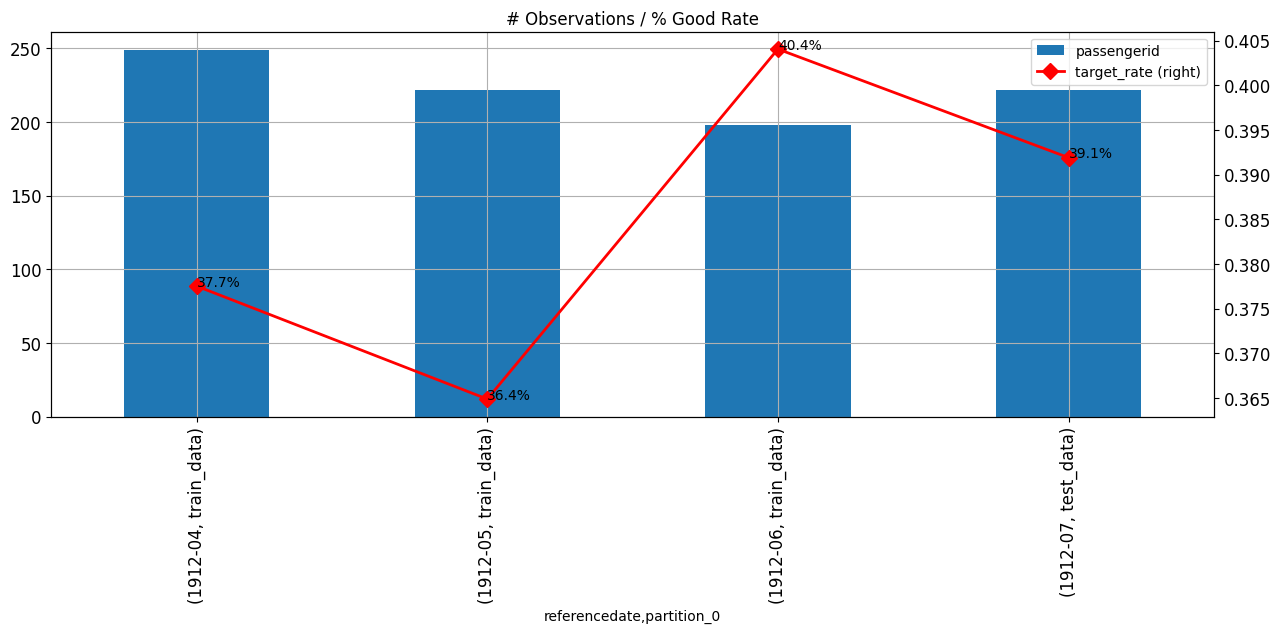

In [32]:
#plot the final dataset with time period, train and test definitions
dataprep_target = dataprep_df[[VarDate, VarId, VarTarget, 'partition_0']].groupby(by=[VarDate, 'partition_0']).agg({VarId:'count', VarTarget:'sum'})
dataprep_target['target_rate'] = dataprep_target[VarTarget] / dataprep_target[VarId]


dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations / % Good Rate"))
ax = dataprep_target.target_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
for p in range(len(dataprep_target)):
    ax.annotate(str('{0:.1%}'.format(int(dataprep_target.reset_index().iloc[p,4]*1000)/1000)), (dataprep_target.reset_index().index.values[p], dataprep_target.reset_index().iloc[p,4]*1))

## 3.1 Treatment of Numeric Missing Data

In [10]:
#Create the "Missing" category for missing values in string vaviables
# dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [33]:
#Tratamento da idade
# dataprep_df['age_mean'] = dataprep_df['age'].fillna(dataprep_df['age'].mean())

## 3.2 Outliers Removing

In [35]:
# var = 'max_salary_offered_to_prev_application'

# q_low = dataprep_df[var].quantile(0.00012)
# q_hi  = dataprep_df[var].quantile(0.9999)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: ' 
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1) 
#       + " | " 
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 4. Modeling

## 4.1 Traning Models with SageMaker Autopilot

### 4.1.1 SageMaker Setup

In [ ]:
region = my_boto3_session.region_name
session = sagemaker.Session(my_boto3_session)

# You can modify the following to use a bucket of your choosing
prefix = "models/%s/sagemaker-temp" % ModelName

role = get_execution_role()

# # This is the client we will use to interact with SageMaker AutoPilot
sm = my_boto3_session.client(service_name="sagemaker", region_name=region)

input_data_config = [
    {
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": 's3://%s/databases/%s/train_data/train_data.csv' % (bucket, ModelName),
            }
        },
        "TargetAttributeName": VarTarget,
    }
]

output_data_config = {"S3OutputPath": "s3://%s/%s" % (bucket, prefix)}

### 4.1.2 SageMaker Setup and Run Auto Pilot

In [ ]:
timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())

auto_ml_job_name = "autopilot-" + ModelName.replace('_', '-')[0:10] + '-' + timestamp_suffix
print("AutoMLJobName: " + auto_ml_job_name)

#Run SageMaker Autopilot
sm.create_auto_ml_job(
    AutoMLJobName=auto_ml_job_name,
    InputDataConfig=input_data_config,
    OutputDataConfig=output_data_config,
    AutoMLJobConfig={"CompletionCriteria": {"MaxCandidates": 20}},
    RoleArn=role
)

In [ ]:
print("JobStatus - Secondary Status")
print("------------------------------")

describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print(describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"] + " - " + strftime("%d-%H-%M-%S", gmtime()))
job_run_status = describe_response["AutoMLJobStatus"]

while job_run_status not in ("Failed", "Completed", "Stopped"):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response["AutoMLJobStatus"]

    print(
        describe_response["AutoMLJobStatus"] + " - " + describe_response["AutoMLJobSecondaryStatus"] + " - " + strftime("%d-%H-%M-%S", gmtime())
    )
    sleep(30)

### 4.1.3 Create SageMaker Endpoint and Predictor with the Best Candidate

In [ ]:
#Select best candidate
best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)["BestCandidate"]
best_candidate_name = best_candidate["CandidateName"]

#Add probability and probabilities to the SAGEMAKER_INFERENCE_OUTPUT
for i in range(len(best_candidate["InferenceContainers"])):
    best_candidate["InferenceContainers"][i]['Environment']['SAGEMAKER_INFERENCE_INPUT']='predicted_label, probability, probabilities'
    best_candidate["InferenceContainers"][i]['Environment']['SAGEMAKER_INFERENCE_OUTPUT']='predicted_label, probability, probabilities'

#Create endpoint configuration
timestamp_suffix = strftime("%d-%H-%M-%S", gmtime())
model_name = best_candidate_name + timestamp_suffix + "-model"
model_arn = sm.create_model(
    Containers=best_candidate["InferenceContainers"], ModelName=model_name, ExecutionRoleArn=role
)

epc_name = best_candidate_name + timestamp_suffix + "-epc"
ep_config = sm.create_endpoint_config(
    EndpointConfigName=epc_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.2xlarge",
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "main",
        }
    ],
)

#Create end endpoint
ep_name = best_candidate_name + timestamp_suffix + "-ep"
create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
print("ep_name: " + str(ep_name))

In [ ]:
#Create Predictor
sm_predictor = Predictor(
    endpoint_name=ep_name,
    sagemaker_session=session,
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer(),
)

## 4.2 Traning Models with H2O AutoML

## 4.2.1 Creating context and H2O and Importing data into the H2O context

In [36]:
# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = '4G')
# h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_342"; OpenJDK Runtime Environment Corretto-8.342.07.4 (build 1.8.0_342-b07); OpenJDK 64-Bit Server VM Corretto-8.342.07.4 (build 25.342-b07, mixed mode)
  Starting server from /var/lang/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmptyo5jt9i
  JVM stdout: /tmp/tmptyo5jt9i/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmptyo5jt9i/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2OConnectionError: Version mismatch. H2O is version 3.36.1.2, but the h2o-python package is version 3.36.1.3. Install the matching h2o-Python version from - http://h2o-release.s3.amazonaws.com/h2o/rel-zumbo/2/index.html.

In [17]:
#Import TRAINING base to the H20 context
data_hdf = h2o.H2OFrame(dataprep_df.query('partition_0 == "train_data"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
data_hdf[VarTarget] = data_hdf[VarTarget].asfactor()
for col_name in CAT:
    data_hdf[col_name] = data_hdf[col_name].asfactor()
for col_name in NUM:
    data_hdf[col_name] = data_hdf[col_name].asnumeric()
    
# Partition data into 90%, 10% chunks
# Setting a seed will guarantee reproducibility
train_hdf, valid_hdf = data_hdf.split_frame(ratios=[0.90], destination_frames=['train_hdf', 'valid_hdf'], seed=1)
        
#Notice that `split_frame()` uses approximate splitting not exact splitting (for efficiency), so these are not exactly 90%, 10% of the total rows.
print('Training: ' + str(train_hdf.nrow))
print('Validation: ' + str(valid_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training: 252915
Validation: 28214


In [18]:
#Import TEST base to the H20 context
test_hdf = h2o.H2OFrame(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])])

# Conversion of Target variables and categorical features to factor (enum)
#no H2O it is necessary that the categorical variables are transformed into a factor
test_hdf[VarTarget] = test_hdf[VarTarget].asfactor()
for col_name in CAT:
    test_hdf[col_name] = test_hdf[col_name].asfactor()
for col_name in NUM:
    test_hdf[col_name] = test_hdf[col_name].asnumeric()
    
print('Test: ' + str(test_hdf.nrow))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test: 46846


## 4.2.2 Train the H2O Champion algorithm with new data

In [20]:
h2o_champion = h2o.load_model('StackedEnsemble_BestOfFamily_3_AutoML_1_20220713_190002')
h2o_champion

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_3_AutoML_1_20220713_190002

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.06893082825742612
RMSE: 0.2625468115544847
LogLoss: 0.24045350855349112
Null degrees of freedom: 9938
Residual degrees of freedom: 9932
Null deviance: 6343.288240175256
Residual deviance: 4779.734843026296
AIC: 4793.734843026296
AUC: 0.8601547800557036
AUCPR: 0.5060786625477057
Gini: 0.7203095601114071

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2030108340131232: 


,,0,1,Error,Rate
0,0,8482.0,490.0,0.0546,(490.0/8972.0)
1,1,496.0,471.0,0.5129,(496.0/967.0)
2,Total,8978.0,961.0,0.0992,(986.0/9939.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.203011,0.488589,165.0
1,max f2,0.124546,0.562239,233.0
2,max f0point5,0.274337,0.533659,121.0
3,max accuracy,0.312708,0.917296,101.0
4,max precision,0.962936,1.000000,0.0
5,max recall,0.022860,1.000000,378.0
6,max specificity,0.962936,1.000000,0.0
7,max absolute_mcc,0.203011,0.433662,165.0
8,max min_per_class_accuracy,0.110973,0.770424,248.0
9,max mean_per_class_accuracy,0.108586,0.771609,251.0



Gains/Lift Table: Avg response rate:  9,73 %, avg score:  9,52 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010061,0.472451,9.558707,9.558707,0.930000,0.595989,0.930000,0.595989,0.096174,0.096174,855.870734,855.870734,0.095394
1,2,0.020022,0.376307,7.267400,8.418811,0.707071,0.419099,0.819095,0.507988,0.072389,0.168563,626.739996,741.881070,0.164550
2,3,0.030084,0.326252,5.755781,7.528165,0.560000,0.349631,0.732441,0.455026,0.057911,0.226474,475.578077,652.816524,0.217557
3,4,0.040044,0.290641,5.191000,6.946810,0.505051,0.309221,0.675879,0.418758,0.051706,0.278180,419.099997,594.681006,0.263802
4,5,0.050005,0.268499,4.568080,6.472979,0.444444,0.279563,0.629779,0.391031,0.045502,0.323681,356.807997,547.297851,0.303173
5,6,0.100010,0.199242,3.350232,4.911605,0.325956,0.228476,0.477867,0.309754,0.167528,0.491210,235.023169,391.160510,0.433363
6,7,0.150015,0.163438,1.881920,3.901710,0.183099,0.180453,0.379611,0.266653,0.094105,0.585315,88.192027,290.171016,0.482217
7,8,0.200020,0.138636,1.757838,3.365742,0.171026,0.151019,0.327465,0.237745,0.087901,0.673216,75.783762,236.574202,0.524197
8,9,0.300030,0.104896,1.137424,2.622969,0.110664,0.120578,0.255198,0.198689,0.113754,0.786970,13.742434,162.296946,0.539422
9,10,0.400040,0.082960,0.734156,2.150766,0.071429,0.093290,0.209256,0.172339,0.073423,0.860393,-26.584429,115.076602,0.509969




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.0793541377127733
RMSE: 0.2816986647337422
LogLoss: 0.28037483967256394
Null degrees of freedom: 21042
Residual degrees of freedom: 21036
Null deviance: 13361.144841730791
Residual deviance: 11799.855502459526
AIC: 11813.855502459526
AUC: 0.7470639666964464
AUCPR: 0.2747495772056042
Gini: 0.49412793339289274

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17185321984123705: 


,,0,1,Error,Rate
0,0,16818.0,2193.0,0.1154,(2193.0/19011.0)
1,1,1225.0,807.0,0.6029,(1225.0/2032.0)
2,Total,18043.0,3000.0,0.1624,(3418.0/21043.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.171853,0.320747,193.0
1,max f2,0.086713,0.448106,283.0
2,max f0point5,0.222410,0.303555,153.0
3,max accuracy,0.558675,0.905859,37.0
4,max precision,0.927083,1.000000,0.0
5,max recall,0.011707,1.000000,394.0
6,max specificity,0.927083,1.000000,0.0
7,max absolute_mcc,0.171853,0.238055,193.0
8,max min_per_class_accuracy,0.095454,0.680080,271.0
9,max mean_per_class_accuracy,0.086713,0.682669,283.0



Gains/Lift Table: Avg response rate:  9,66 %, avg score:  9,60 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010027,0.436583,5.840479,5.840479,0.563981,0.562954,0.563981,0.562954,0.058563,0.058563,484.047888,484.047888,0.053724
1,2,0.020007,0.360936,3.402622,4.624446,0.328571,0.392382,0.446556,0.477871,0.033957,0.092520,240.262233,362.444592,0.080264
2,3,0.030034,0.311158,3.141098,4.129214,0.303318,0.333611,0.398734,0.429708,0.031496,0.124016,214.109788,312.921422,0.104027
3,4,0.040013,0.282251,2.810862,3.800409,0.271429,0.295356,0.366983,0.396200,0.028051,0.152067,181.086192,280.040901,0.124031
4,5,0.050040,0.259654,3.190178,3.678131,0.308057,0.270295,0.355176,0.370971,0.031988,0.184055,219.017754,267.813091,0.148339
5,6,0.100033,0.201439,2.490513,3.084604,0.240494,0.227078,0.297862,0.299059,0.124508,0.308563,149.051254,208.460382,0.230819
6,7,0.150026,0.166411,1.949097,2.706221,0.188213,0.183129,0.261324,0.260428,0.097441,0.406004,94.909677,170.622136,0.283338
7,8,0.200019,0.141424,1.545496,2.416109,0.149240,0.152950,0.233310,0.233565,0.077264,0.483268,54.549592,141.610895,0.313524
8,9,0.300005,0.108620,1.383071,2.071818,0.133555,0.123606,0.200063,0.196917,0.138287,0.621555,38.307119,107.181757,0.355919
9,10,0.399990,0.085406,1.077910,1.823370,0.104087,0.096418,0.176072,0.171796,0.107776,0.729331,7.790958,82.337010,0.364542




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.07883922520442452
RMSE: 0.28078323526240756
LogLoss: 0.2793421005955514
Null degrees of freedom: 187465
Residual degrees of freedom: 187459
Null deviance: 118246.55504295608
Residual deviance: 104734.29246049128
AIC: 104748.29246049128
AUC: 0.7432099501962256
AUCPR: 0.27004772843951425
Gini: 0.4864199003924512

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1507454756537375: 


,,0,1,Error,Rate
0,0,143741.0,25797.0,0.1522,(25797.0/169538.0)
1,1,9726.0,8202.0,0.5425,(9726.0/17928.0)
2,Total,153467.0,33999.0,0.1895,(35523.0/187466.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.150745,0.315905,220.0
1,max f2,0.086990,0.441568,286.0
2,max f0point5,0.241576,0.304162,155.0
3,max accuracy,0.519604,0.906143,56.0
4,max precision,0.951049,1.000000,0.0
5,max recall,0.005494,1.000000,399.0
6,max specificity,0.951049,1.000000,0.0
7,max absolute_mcc,0.150745,0.233044,220.0
8,max min_per_class_accuracy,0.095016,0.676818,277.0
9,max mean_per_class_accuracy,0.093357,0.679032,279.0



Gains/Lift Table: Avg response rate:  9,56 %, avg score:  9,56 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010002,0.435218,5.788776,5.788776,0.553600,0.563771,0.553600,0.563771,0.057898,0.057898,478.877608,478.877608,0.052961
1,2,0.020004,0.355611,3.831300,4.810038,0.366400,0.390366,0.460000,0.477069,0.038320,0.096218,283.129978,381.003793,0.084274
2,3,0.030000,0.313386,3.119126,4.246601,0.298292,0.332651,0.406117,0.428947,0.031180,0.127398,211.912580,324.660099,0.107698
3,4,0.040002,0.285141,3.162077,3.975434,0.302400,0.298635,0.380184,0.396364,0.031627,0.159025,216.207711,297.543387,0.131609
4,5,0.050004,0.263790,2.777274,3.735776,0.265600,0.274047,0.357265,0.371898,0.027778,0.186803,177.727407,273.577634,0.151265
5,6,0.100002,0.201508,2.384057,3.059953,0.227995,0.228495,0.292633,0.300200,0.119199,0.306002,138.405667,205.995256,0.227783
6,7,0.150001,0.166215,1.955663,2.691869,0.187027,0.182557,0.257432,0.260987,0.097780,0.403782,95.566277,169.186905,0.280618
7,8,0.200004,0.141420,1.638655,2.428551,0.156710,0.153255,0.232250,0.234053,0.081939,0.485721,63.865496,142.855148,0.315930
8,9,0.300001,0.107882,1.321439,2.059527,0.126374,0.123344,0.196959,0.197151,0.132140,0.617860,32.143899,105.952711,0.351472
9,10,0.400003,0.084829,1.035788,1.803589,0.099056,0.095698,0.172483,0.171788,0.103581,0.721441,3.578781,80.358887,0.355429




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.819650,0.008061,0.810197,0.820329,0.827856,0.827097,0.812773
1,auc,0.743314,0.004973,0.735666,0.741715,0.745068,0.748894,0.745225
2,err,0.180350,0.008061,0.189803,0.179671,0.172144,0.172903,0.187227
3,err_count,6762.000000,307.911500,7144.000000,6747.000000,6495.000000,6432.000000,6992.000000
4,f0point5,0.272387,0.007354,0.260910,0.272633,0.277737,0.279723,0.270931
5,f1,0.317232,0.005573,0.307752,0.317865,0.317967,0.321805,0.320769
6,f2,0.379976,0.008132,0.375094,0.381091,0.371826,0.378792,0.393076
7,lift_top_group,5.756344,0.292298,5.301143,5.861708,5.747919,6.107515,5.763437
8,logloss,0.279314,0.002009,0.282660,0.278890,0.278948,0.277210,0.278862
9,max_per_class_error,0.562048,0.016089,0.560841,0.560648,0.580842,0.570504,0.537405



See the whole table with table.as_data_frame()


In [19]:
## This is the champion previous trained algorithms that will be used as comparison for the new experiments
vModel='h2o_champion_'

#Execution time of the model
start = dt.datetime.now()

from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o_champion = H2OGradientBoostingEstimator(model_id='%s%s_%s' % (vModel, ModelId, str(dt.datetime.now())[:19].replace('-',"").replace(':',"").replace(' ',"_")),
                                    nfolds= 5,
                                    keep_cross_validation_models= False,
                                    keep_cross_validation_predictions= True,
                                    keep_cross_validation_fold_assignment= False,
                                    score_each_iteration= False,
                                    score_tree_interval= 5,
                                    fold_assignment='Modulo',
                                    fold_column= None,
                                    ignore_const_cols= True,
                                    offset_column= None,
                                    weights_column= None,
                                    balance_classes= False,
                                    class_sampling_factors= None,
                                    max_after_balance_size= 5.0,
                                    max_confusion_matrix_size= 20,
                                    ntrees= 120,
                                    max_depth= 4,
                                    min_rows= 100.0,
                                    nbins= 20,
                                    nbins_top_level= 1024,
                                    nbins_cats= 1024,
                                    r2_stopping= 1.7976931348623157e+308,
                                    stopping_rounds= 2,
                                    stopping_metric='AUCPR',
                                    stopping_tolerance= 0.002303474948339114,
                                    max_runtime_secs= 31688.0,
                                    seed= 101,
                                    build_tree_one_node= False,
                                    learn_rate= 0.1,
                                    learn_rate_annealing= 1.0,
                                    distribution='bernoulli',
                                    quantile_alpha= 0.5,
                                    tweedie_power= 1.5,
                                    huber_alpha= 0.9,
                                    checkpoint= None,
                                    sample_rate= 0.9,
                                    sample_rate_per_class= None,
                                    col_sample_rate= 0.4,
                                    col_sample_rate_change_per_level= 1.0,
                                    col_sample_rate_per_tree= 0.7,
                                    min_split_improvement= 1e-05,
                                    histogram_type='UniformAdaptive',
                                    max_abs_leafnode_pred= 1.7976931348623157e+308,
                                    pred_noise_bandwidth= 0.0,
                                    categorical_encoding='Enum',
                                    calibrate_model= False,
                                    calibration_frame= None,
                                    custom_metric_func= None,
                                    custom_distribution_func= None,
                                    export_checkpoints_dir= None,
                                    monotone_constraints= None,
                                    check_constant_response= True,
                                    gainslift_bins= -1,
                                    auc_type='AUTO',
                                    interaction_constraints= None)

# The use of a validation_frame is recommended with using early stopping
h2o_champion.train(x=selected_features, y=VarTarget, training_frame=train_hdf, validation_frame=valid_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")
print(h2o_champion)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%

Execution time: 0:00:26.374571

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  h2o_champion_prop_apply_candidates_v18_20220907_235145


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,82.0,82.0,36116.0,4.0,4.0,4.0,9.0,16.0,14.841463




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07570049841426102
RMSE: 0.27513723560118325
LogLoss: 0.2690332748277046
Mean Per-Class Error: 0.3405037579599754
AUC: 0.7688394828721928
AUCPR: 0.3216444441659647
Gini: 0.5376789657443857

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1601981197066666: 


,,0,1,Error,Rate
0,0,202579.0,26371.0,0.1152,(26371.0/228950.0)
1,1,13560.0,10405.0,0.5658,(13560.0/23965.0)
2,Total,216139.0,36776.0,0.1579,(39931.0/252915.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.160198,0.342602,209.0
1,max f2,0.095802,0.460607,277.0
2,max f0point5,0.270317,0.357717,136.0
3,max accuracy,0.420702,0.909270,78.0
4,max precision,0.938157,1.000000,0.0
5,max recall,0.014461,1.000000,398.0
6,max specificity,0.938157,1.000000,0.0
7,max absolute_mcc,0.167912,0.265210,203.0
8,max min_per_class_accuracy,0.094989,0.697519,278.0
9,max mean_per_class_accuracy,0.097532,0.698402,275.0



Gains/Lift Table: Avg response rate:  9,48 %, avg score:  9,48 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.426259,7.329062,7.329062,0.694466,0.561840,0.694466,0.561840,0.073315,0.073315,632.906198,632.906198,0.069939
1,2,0.020003,0.341846,4.719662,6.024620,0.447212,0.378085,0.570864,0.469981,0.047194,0.120509,371.966235,502.462006,0.111027
2,3,0.030002,0.299541,3.910100,5.319873,0.370502,0.318897,0.504085,0.419626,0.039099,0.159608,291.010046,431.987308,0.143172
3,4,0.040002,0.271268,3.284151,4.810993,0.311190,0.284719,0.455866,0.385903,0.032840,0.192447,228.415055,381.099275,0.168403
4,5,0.050001,0.250970,2.954484,4.439720,0.279953,0.260725,0.420686,0.360869,0.029543,0.221990,195.448359,343.972028,0.189992
5,6,0.100002,0.191111,2.428494,3.434107,0.230112,0.217547,0.325399,0.289208,0.121427,0.343417,142.849361,243.410695,0.268895
6,7,0.150003,0.157135,1.971169,2.946461,0.186778,0.172848,0.279192,0.250422,0.098560,0.441978,97.116904,194.646098,0.322537
7,8,0.200000,0.134032,1.665027,2.626121,0.157770,0.144814,0.248839,0.224021,0.083246,0.525224,66.502677,162.612143,0.359267
8,9,0.300002,0.103929,1.311887,2.188038,0.124308,0.117791,0.207328,0.188611,0.131191,0.656416,31.188727,118.803760,0.393721
9,10,0.400000,0.082907,0.978947,1.885771,0.092760,0.092820,0.178687,0.164664,0.097893,0.754308,-2.105304,88.577092,0.391395




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.0794496929477903
RMSE: 0.28186821911629256
LogLoss: 0.2819044807780923
Mean Per-Class Error: 0.34910615669400247
AUC: 0.73573821563802
AUCPR: 0.2523125961004397
Gini: 0.47147643127604

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13707249427018833: 


,,0,1,Error,Rate
0,0,21270.0,4257.0,0.1668,(4257.0/25527.0)
1,1,1428.0,1259.0,0.5314,(1428.0/2687.0)
2,Total,22698.0,5516.0,0.2015,(5685.0/28214.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.137072,0.306961,223.0
1,max f2,0.079652,0.436071,295.0
2,max f0point5,0.241087,0.294020,140.0
3,max accuracy,0.549782,0.906252,36.0
4,max precision,0.915827,1.000000,0.0
5,max recall,0.014671,1.000000,398.0
6,max specificity,0.915827,1.000000,0.0
7,max absolute_mcc,0.126813,0.224276,235.0
8,max min_per_class_accuracy,0.090925,0.668860,279.0
9,max mean_per_class_accuracy,0.079652,0.672932,295.0



Gains/Lift Table: Avg response rate:  9,52 %, avg score:  9,47 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010030,0.415656,5.268645,5.268645,0.501767,0.539198,0.501767,0.539198,0.052847,0.052847,426.864461,426.864461,0.047323
1,2,0.020026,0.335029,3.984113,4.627516,0.379433,0.369714,0.440708,0.454606,0.039821,0.092668,298.411316,362.751564,0.080289
2,3,0.030021,0.293109,3.202184,4.152966,0.304965,0.312704,0.395514,0.407361,0.032006,0.124674,220.218441,315.296616,0.104617
3,4,0.040016,0.267822,2.867072,3.831777,0.273050,0.279901,0.364925,0.375524,0.028656,0.153331,186.707209,283.177738,0.125243
4,5,0.050011,0.248647,2.680899,3.601765,0.255319,0.257403,0.343019,0.351917,0.026796,0.180127,168.089857,260.176475,0.143812
5,6,0.100021,0.191271,2.105991,2.853878,0.200567,0.217137,0.271793,0.284527,0.105322,0.285448,110.599055,185.387765,0.204945
6,7,0.149996,0.157016,1.943651,2.550612,0.185106,0.172476,0.242911,0.247194,0.097134,0.382583,94.365147,155.061231,0.257069
7,8,0.200007,0.135149,1.845532,2.374311,0.175762,0.145262,0.226121,0.221707,0.092296,0.474879,84.553235,137.431108,0.303805
8,9,0.299993,0.104603,1.358585,2.035776,0.129387,0.118477,0.193880,0.187301,0.135839,0.610718,35.858487,103.577568,0.343433
9,10,0.400014,0.083753,1.004624,1.777942,0.095677,0.093500,0.169325,0.163847,0.100484,0.711202,0.462447,77.794219,0.343944




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07883340283015981
RMSE: 0.28077286697642245
LogLoss: 0.28011805435826376
Mean Per-Class Error: 0.3562173630130604
AUC: 0.7377418134575761
AUCPR: 0.2566871645776296
Gini: 0.4754836269151521

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14802850994763786: 


,,0,1,Error,Rate
0,0,196769.0,32181.0,0.1406,(32181.0/228950.0)
1,1,13705.0,10260.0,0.5719,(13705.0/23965.0)
2,Total,210474.0,42441.0,0.1814,(45886.0/252915.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.148029,0.309008,222.0
1,max f2,0.086008,0.435680,290.0
2,max f0point5,0.249056,0.295310,146.0
3,max accuracy,0.581726,0.906435,40.0
4,max precision,0.976535,1.000000,0.0
5,max recall,0.013274,1.000000,398.0
6,max specificity,0.976535,1.000000,0.0
7,max absolute_mcc,0.148029,0.225374,222.0
8,max min_per_class_accuracy,0.090976,0.675043,284.0
9,max mean_per_class_accuracy,0.090064,0.675892,285.0



Gains/Lift Table: Avg response rate:  9,48 %, avg score:  9,44 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.421004,5.489497,5.489497,0.520158,0.546606,0.520158,0.546606,0.054913,0.054913,448.949662,448.949662,0.049611
1,2,0.020003,0.339341,3.797429,4.643630,0.359826,0.374414,0.440008,0.460527,0.037972,0.092885,279.742948,364.363028,0.080512
2,3,0.030002,0.297413,3.200691,4.162714,0.303282,0.316444,0.394439,0.412506,0.032005,0.124890,220.069056,316.271376,0.104821
3,4,0.040002,0.269758,3.046290,3.883635,0.288652,0.282721,0.367994,0.380063,0.030461,0.155352,204.628958,288.363530,0.127424
4,5,0.050001,0.249514,2.791737,3.665273,0.264531,0.259186,0.347303,0.355889,0.027916,0.183267,179.173661,266.527283,0.147216
5,6,0.100002,0.190414,2.294968,2.980121,0.217460,0.216193,0.282382,0.286041,0.114751,0.298018,129.496819,198.012051,0.218743
6,7,0.150003,0.156576,1.938622,2.632954,0.183694,0.172083,0.249486,0.248055,0.096933,0.394951,93.862222,163.295442,0.270588
7,8,0.200000,0.134318,1.659185,2.389526,0.157216,0.144758,0.226420,0.222232,0.082954,0.477905,65.918457,138.952639,0.306995
8,9,0.300002,0.103749,1.342765,2.040601,0.127234,0.118011,0.193357,0.187491,0.134279,0.612184,34.276503,104.060134,0.344860
9,10,0.400000,0.082566,1.033611,1.788859,0.097940,0.092570,0.169504,0.163761,0.103359,0.715544,3.361109,78.885875,0.348573




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.816800,0.005381,0.810075,0.820928,0.821126,0.811854,0.820019
1,auc,0.737914,0.004355,0.739260,0.736194,0.743662,0.738661,0.731791
2,err,0.183200,0.005381,0.189925,0.179072,0.178874,0.188146,0.179981
3,err_count,9266.800000,272.172180,9607.000000,9058.000000,9048.000000,9517.000000,9104.000000
4,f0point5,0.264532,0.003667,0.259583,0.263914,0.268840,0.262978,0.267348
5,f1,0.309824,0.002956,0.308202,0.306538,0.314130,0.311310,0.308942
6,f2,0.373971,0.007642,0.379231,0.365582,0.377771,0.381410,0.365862
7,lift_top_group,5.488766,0.242772,5.839746,5.445477,5.246972,5.297615,5.614018
8,logloss,0.280099,0.002776,0.278834,0.279722,0.277079,0.280299,0.284563
9,max_per_class_error,0.565970,0.015181,0.551926,0.580557,0.563238,0.551221,0.582906



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-09-07 23:52:07,21.439 sec,0.0,0.292876,0.313404,0.500000,0.094755,1.000000,0.905245,0.293542,0.314490,0.500000,0.095236,1.000000,0.904764
1,,2022-09-07 23:52:07,22.185 sec,5.0,0.286725,0.296331,0.717534,0.245497,5.577095,0.190424,0.288072,0.298946,0.708031,0.222653,4.958421,0.181896
2,,2022-09-07 23:52:08,22.406 sec,10.0,0.283798,0.288939,0.724813,0.254641,5.806519,0.170156,0.285652,0.292456,0.714390,0.228452,4.971820,0.177855
3,,2022-09-07 23:52:08,22.616 sec,15.0,0.282159,0.285043,0.730388,0.262767,5.969202,0.204223,0.284486,0.289458,0.717670,0.233560,5.157335,0.200716
4,,2022-09-07 23:52:08,22.822 sec,20.0,0.280908,0.282170,0.735800,0.270554,6.190283,0.194899,0.283748,0.287479,0.721572,0.237234,5.046026,0.226909
5,,2022-09-07 23:52:08,23.025 sec,25.0,0.280075,0.280106,0.740278,0.275574,6.152741,0.186047,0.283294,0.286154,0.724174,0.239820,5.157335,0.228893
6,,2022-09-07 23:52:09,23.242 sec,30.0,0.279411,0.278607,0.743454,0.280722,6.340452,0.190479,0.282999,0.285326,0.725923,0.241939,5.194438,0.240164
7,,2022-09-07 23:52:09,23.451 sec,35.0,0.278808,0.277196,0.747226,0.286082,6.544848,0.177036,0.282777,0.284671,0.727538,0.243645,5.454160,0.205643
8,,2022-09-07 23:52:09,23.654 sec,40.0,0.278244,0.275932,0.750355,0.291405,6.661646,0.156187,0.282585,0.284120,0.728920,0.245376,5.342851,0.192918
9,,2022-09-07 23:52:09,23.892 sec,45.0,0.277794,0.274914,0.753145,0.295857,6.749244,0.159061,0.282409,0.283669,0.730066,0.247374,5.379954,0.211349



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,days_since_last_application,1758.276367,1.000000,0.152997
1,prev_approach_status,1376.679321,0.782971,0.119792
2,company_classification_migration,1175.300537,0.668439,0.102269
3,prev_application_job_area_to_job_area,977.806519,0.556117,0.085084
4,prev_approach_job_area_to_job_area,884.524658,0.503063,0.076967
5,prev_application_company_classification_migration,800.552063,0.455305,0.069660
6,prev_approach_company_classification_migration,568.453308,0.323301,0.049464
7,application_current_phase_active,453.674866,0.258023,0.039477
8,talent_info_source,378.650940,0.215353,0.032948
9,previous_approaches_qty,321.978973,0.183122,0.028017



See the whole table with table.as_data_frame()



## 4.2.3 Using H2O AutoML to performe all algorithms

In [20]:
##H2O Parameters:

vModel='AUTOML'

#Set the maximum time in seconds for the H20 AutoML
max_runtime_secs=60*60*8

#Define metrics to select the best model in AutoML
sort_metric = 'AUCPR'

#Execution time of the model
start = dt.datetime.now()

from h2o.automl import H2OAutoML
AUTOML = H2OAutoML(seed=1,
#                    exclude_algos=["StackedEnsemble"],
                   max_runtime_secs = max_runtime_secs,
                   stopping_metric = sort_metric,
                   sort_metric = sort_metric)
AUTOML.train(x=selected_features, y=VarTarget, training_frame = train_hdf, validation_frame = valid_hdf, leaderboard_frame=test_hdf)

#Execution time of the model
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+ "Execution time: " + str(execution_time) + "\n")

AutoML progress: |
23:52:14.323: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
23:52:14.338: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%

Execution time: 8:01:01.239425



In [21]:
#View the AutoML Leaderboard
lb = AUTOML.leaderboard
print(lb.head(rows=lb.nrows))

model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_3_AutoML_1_20220907_235214,0.260485,0.738341,0.283195,0.35542,0.282833,0.0799942
StackedEnsemble_BestOfFamily_4_AutoML_1_20220907_235214,0.260198,0.737468,0.2836,0.363854,0.282961,0.0800667
GBM_grid_1_AutoML_1_20220907_235214_model_274,0.258642,0.735341,0.283774,0.358253,0.282911,0.0800385
GBM_grid_1_AutoML_1_20220907_235214_model_278,0.258573,0.735457,0.28389,0.358073,0.283005,0.0800918
GBM_grid_1_AutoML_1_20220907_235214_model_286,0.258522,0.734011,0.283973,0.352782,0.282934,0.0800515
GBM_grid_1_AutoML_1_20220907_235214_model_94,0.258459,0.734516,0.284002,0.349238,0.283003,0.080091
GBM_grid_1_AutoML_1_20220907_235214_model_184,0.258053,0.733888,0.284241,0.358068,0.283122,0.080158
GBM_grid_1_AutoML_1_20220907_235214_model_20,0.258018,0.734647,0.284053,0.342361,0.28305,0.0801172
GBM_grid_1_AutoML_1_20220907_235214_model_171,0.257833,0.734234,0.284095,0.354241,0.283029,0.0801052
GBM_grid_1_AutoML_1_20220907_235214_model_101,0.257737,0.734678,0.284065,0.359142,0.283117,0.0801553


In [22]:
#Choose the desired AutoML model
best_automl_position=0
if len(AUTOML.leaderboard) > 0:
    best_AutoML = h2o.get_model(AUTOML.leaderboard[best_automl_position, 0])
    print(best_AutoML)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_3_AutoML_1_20220907_235214

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.06167272262311116
RMSE: 0.24833993360535306
LogLoss: 0.22018122271499166
Null degrees of freedom: 9996
Residual degrees of freedom: 9949
Null deviance: 6165.6812289595
Residual deviance: 4402.303366963543
AIC: 4498.303366963543
AUC: 0.8877178368845036
AUCPR: 0.5867116756178992
Gini: 0.7754356737690071

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21837198768556898: 


,,0,1,Error,Rate
0,0,8656.0,416.0,0.0459,(416.0/9072.0)
1,1,433.0,492.0,0.4681,(433.0/925.0)
2,Total,9089.0,908.0,0.0849,(849.0/9997.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.218372,0.536825,168.0
1,max f2,0.128345,0.601002,241.0
2,max f0point5,0.299844,0.622844,122.0
3,max accuracy,0.299844,0.930379,122.0
4,max precision,0.941790,1.000000,0.0
5,max recall,0.029889,1.000000,372.0
6,max specificity,0.941790,1.000000,0.0
7,max absolute_mcc,0.254950,0.499908,146.0
8,max min_per_class_accuracy,0.120379,0.802162,250.0
9,max mean_per_class_accuracy,0.124702,0.804075,245.0



Gains/Lift Table: Avg response rate:  9,25 %, avg score:  9,83 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.508704,10.375265,10.375265,0.960000,0.649167,0.960000,0.649167,0.103784,0.103784,937.526486,937.526486,0.103343
1,2,0.020006,0.413832,9.618735,9.997000,0.890000,0.457857,0.925000,0.553512,0.096216,0.200000,861.873514,899.700000,0.198347
2,3,0.030009,0.347033,7.349146,9.114382,0.680000,0.377952,0.843333,0.494992,0.073514,0.273514,634.914595,811.438198,0.268333
3,4,0.040012,0.308827,6.160314,8.375865,0.570000,0.328658,0.775000,0.453409,0.061622,0.335135,516.031351,737.586486,0.325215
4,5,0.050015,0.279911,5.079557,7.716603,0.470000,0.292220,0.714000,0.421171,0.050811,0.385946,407.955676,671.660324,0.370183
5,6,0.100030,0.206905,3.350346,5.533475,0.310000,0.237619,0.512000,0.329395,0.167568,0.553514,235.034595,453.347459,0.499722
6,7,0.150045,0.166100,1.945362,4.337437,0.180000,0.184879,0.401333,0.281223,0.097297,0.650811,94.536216,333.743712,0.551825
7,8,0.200060,0.140282,1.621135,3.658362,0.150000,0.152228,0.338500,0.248974,0.081081,0.731892,62.113514,265.836162,0.586059
8,9,0.299990,0.105528,1.081839,2.800093,0.100100,0.121441,0.259086,0.206492,0.108108,0.840000,8.183860,180.009336,0.595071
9,10,0.400020,0.082313,0.626839,2.256644,0.058000,0.093399,0.208802,0.178211,0.062703,0.902703,-37.316108,125.664389,0.553937




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.07877590505071067
RMSE: 0.2806704563197036
LogLoss: 0.27891898429133205
Null degrees of freedom: 28213
Residual degrees of freedom: 28166
Null deviance: 17746.027589215
Residual deviance: 15738.840445591284
AIC: 15834.840445591284
AUC: 0.7442563533326338
AUCPR: 0.2637905487421336
Gini: 0.4885127066652677

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14311010683663514: 


,,0,1,Error,Rate
0,0,21214.0,4313.0,0.169,(4313.0/25527.0)
1,1,1370.0,1317.0,0.5099,(1370.0/2687.0)
2,Total,22584.0,5630.0,0.2014,(5683.0/28214.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.143110,0.316701,224.0
1,max f2,0.081394,0.440713,291.0
2,max f0point5,0.258864,0.303099,136.0
3,max accuracy,0.486941,0.906181,48.0
4,max precision,0.921647,1.000000,0.0
5,max recall,0.011012,1.000000,397.0
6,max specificity,0.921647,1.000000,0.0
7,max absolute_mcc,0.143110,0.235899,224.0
8,max min_per_class_accuracy,0.093503,0.676147,275.0
9,max mean_per_class_accuracy,0.091843,0.679405,277.0



Gains/Lift Table: Avg response rate:  9,52 %, avg score:  9,63 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010030,0.428058,5.862295,5.862295,0.558304,0.541384,0.558304,0.541384,0.058802,0.058802,486.229470,486.229470,0.053905
1,2,0.020026,0.352770,3.723470,4.794775,0.354610,0.384825,0.456637,0.463243,0.037216,0.096018,272.347024,379.477524,0.083991
2,3,0.030021,0.314124,2.904307,4.165363,0.276596,0.332339,0.396694,0.419660,0.029029,0.125047,190.430679,316.536307,0.105029
3,4,0.040016,0.286216,3.202184,3.924782,0.304965,0.299438,0.373782,0.389631,0.032006,0.157052,220.218441,292.478169,0.129356
4,5,0.050011,0.265809,2.792603,3.698506,0.265957,0.275852,0.352232,0.366891,0.027912,0.184965,179.260268,269.850637,0.149159
5,6,0.100021,0.203021,2.351565,3.025036,0.223955,0.230537,0.288094,0.298714,0.117603,0.302568,135.156542,202.503589,0.223867
6,7,0.149996,0.166785,1.876629,2.642415,0.178723,0.183887,0.251654,0.260457,0.093785,0.396353,87.662900,164.241450,0.272288
7,8,0.200007,0.142373,1.882741,2.452462,0.179305,0.154190,0.233564,0.233885,0.094157,0.490510,88.274067,145.246239,0.321081
8,9,0.299993,0.107432,1.287864,2.064309,0.122652,0.123727,0.196597,0.197170,0.128768,0.619278,28.786401,106.430879,0.352893
9,10,0.400014,0.084237,0.993462,1.796550,0.094614,0.095077,0.171097,0.171642,0.099367,0.718645,-0.653803,79.654965,0.352171




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.0783235872309644
RMSE: 0.27986351536233584
LogLoss: 0.27763735647800136
Null degrees of freedom: 252914
Residual degrees of freedom: 252871
Null deviance: 158531.3248999413
Residual deviance: 140437.30402726744
AIC: 140525.30402726744
AUC: 0.7451666019278042
AUCPR: 0.2647855614514693
Gini: 0.4903332038556083

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14717529343735888: 


,,0,1,Error,Rate
0,0,193648.0,35302.0,0.1542,(35302.0/228950.0)
1,1,12783.0,11182.0,0.5334,(12783.0/23965.0)
2,Total,206431.0,46484.0,0.1901,(48085.0/252915.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.147175,0.317450,226.0
1,max f2,0.087978,0.441771,286.0
2,max f0point5,0.238831,0.303563,160.0
3,max accuracy,0.566861,0.906502,45.0
4,max precision,0.959727,1.000000,0.0
5,max recall,0.007111,1.000000,399.0
6,max specificity,0.959727,1.000000,0.0
7,max absolute_mcc,0.147175,0.236232,226.0
8,max min_per_class_accuracy,0.092306,0.680659,281.0
9,max mean_per_class_accuracy,0.091368,0.681735,282.0



Gains/Lift Table: Avg response rate:  9,48 %, avg score:  9,47 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010003,0.435664,5.552067,5.552067,0.526087,0.553526,0.526087,0.553526,0.055539,0.055539,455.206687,455.206687,0.050302
1,2,0.020003,0.358666,3.839159,4.695782,0.363780,0.392595,0.444950,0.473076,0.038389,0.093929,283.915947,369.578246,0.081664
2,3,0.030002,0.315247,3.459417,4.283715,0.327798,0.335210,0.405904,0.427127,0.034592,0.128521,245.941652,328.371480,0.108831
3,4,0.040002,0.287429,2.946138,3.949354,0.279162,0.300460,0.374222,0.395463,0.029460,0.157980,194.613759,294.935355,0.130328
4,5,0.050001,0.266029,2.845986,3.728697,0.269672,0.276445,0.353313,0.371662,0.028458,0.186439,184.598561,272.869741,0.150719
5,6,0.100002,0.201192,2.436004,3.082351,0.230824,0.229677,0.292069,0.300669,0.121803,0.308241,143.600442,208.235091,0.230036
6,7,0.150003,0.164503,2.011227,2.725309,0.190574,0.181563,0.258237,0.260967,0.100563,0.408805,101.122667,172.530950,0.285891
7,8,0.200000,0.139189,1.650004,2.456499,0.156346,0.151206,0.232766,0.233528,0.082495,0.491300,65.000397,145.649906,0.321791
8,9,0.300002,0.105047,1.312722,2.075235,0.124387,0.120863,0.196639,0.195973,0.131275,0.622575,31.272181,107.523495,0.356337
9,10,0.400000,0.081819,1.010243,1.808992,0.095726,0.092725,0.171411,0.170161,0.101022,0.723597,1.024321,80.899228,0.357469




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.818345,0.006706,0.818291,0.814039,0.810620,0.828173,0.820600
1,auc,0.745177,0.003570,0.743038,0.744627,0.747883,0.740767,0.749572
2,err,0.181655,0.006706,0.181709,0.185961,0.189380,0.171827,0.179400
3,err_count,9189.200000,358.028900,9197.000000,9402.000000,9622.000000,8680.000000,9045.000000
4,f0point5,0.271684,0.004639,0.270811,0.265840,0.270904,0.272081,0.278785
5,f1,0.318630,0.005153,0.317578,0.316318,0.323347,0.311767,0.324143
6,f2,0.385486,0.013126,0.383870,0.390457,0.400970,0.365007,0.387128
7,lift_top_group,5.545799,0.067679,5.450210,5.633730,5.575452,5.521930,5.547672
8,logloss,0.277628,0.002147,0.278407,0.274436,0.276865,0.278211,0.280220
9,max_per_class_error,0.551460,0.024480,0.554074,0.537234,0.522633,0.588100,0.555259



See the whole table with table.as_data_frame()



## 4.3 Compare performance on the TEST dataset for all trained models

In [23]:
#Create empty model list
list_models = []

#Define the list of all models that have been executed and should be compared
try:
    list_models.append(sm_predictor)
except NameError:
    pass
try:
    list_models.append(h2o_champion)
except NameError:
    pass
try:
    list_models.append(best_AutoML)
except NameError:
    pass

In [24]:
#Consider all models in the history ./models/candidates/performance_*.csv. To disregard any old version, set erase_modelos = "S":
apagar_modelos = 'N'
if apagar_modelos == 'S':
    os.system('rm %s/models/candidates/performance_*.csv' % OutputPath)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\program files\python37\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'application_current_phase_active' has levels not trained on: ["DesistÃªncias [Vagas Intera]", "Em Espera [Outros projetos]", "Leads Enviados [Cliente]", "Projeto Finalizado [Vagas Intera]", "Projeto Parado [Vagas Intera]"]
  warnings.warn(w)
c:\program files\python37\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'application_status' has levels not trained on: ["STANDBY"]
  warnings.warn(w)
c:\program files\python37\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'prev_application_job_department' has levels not trained on: ["Employer Branding & Experience"]
  warnings.warn(w)
c:\program files\python37\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'prev_approach_job_area' has levels not trained on: ["Financeiro"]
  warnings.warn(w)
c:\program files\python37\lib\site-packages\h2o\job.py:83: UserWa

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\program files\python37\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'application_current_phase_active' has levels not trained on: ["DesistÃªncias [Vagas Intera]", "Em Espera [Outros projetos]", "Leads Enviados [Cliente]", "Projeto Finalizado [Vagas Intera]", "Projeto Parado [Vagas Intera]"]
  warnings.warn(w)
c:\program files\python37\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'application_status' has levels not trained on: ["STANDBY"]
  warnings.warn(w)
c:\program files\python37\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'prev_application_job_department' has levels not trained on: ["Employer Branding & Experience"]
  warnings.warn(w)
c:\program files\python37\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'prev_approach_job_area' has levels not trained on: ["Financeiro"]
  warnings.warn(w)
c:\program files\python37\lib\site-packages\h2o\job.py:83: UserWa

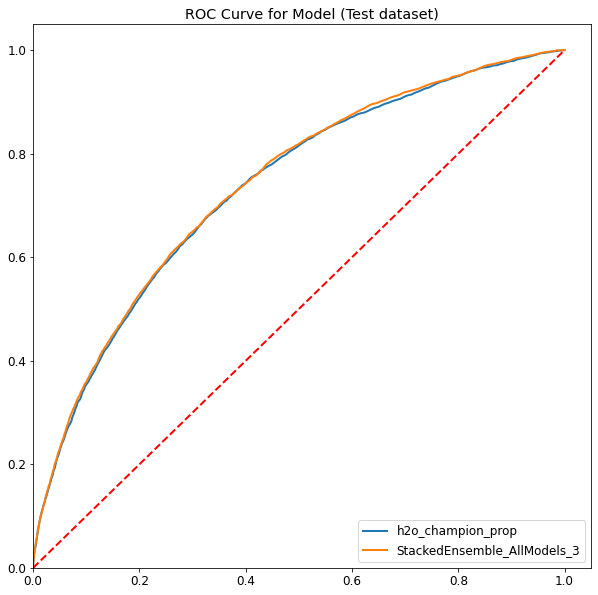

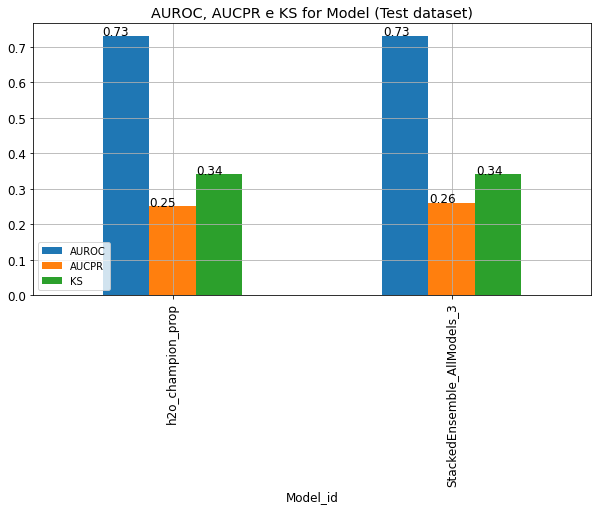

In [25]:
#Compare performance on the TEST dataset for all trained models
plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(10, 10))
for i in list_models:    
    if (isinstance(i, h2o.estimators.gbm.H2OGradientBoostingEstimator)) | (isinstance(i, h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator)):
        #Save all models in H20 format
        h2o.save_model(model=i, path='%s/models/candidates/' % OutputPath, force=True)
        #calculate o KS in test dataset
        h2o_predict = i.predict(test_hdf)
        data = h2o_predict.cbind(test_hdf[VarTarget]).as_data_frame()
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']    
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()

        #Ascertain the performance of all models on the test base
        performance = i.model_performance(test_hdf)

        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, i.model_id), 'w')
        f.write(
            str(i.model_id) + ";"
            + str(performance.accuracy()[0][0]) + ";"
            + str(performance.auc()) + ';'
            + str(performance.aucpr()) + ';'
            + str(performance.logloss()) + ';'
            + str(ks) + ';'
            + str(performance.F1()[0][0]))
        f.write('\n')
        f.close()

        #graph with the ROC curve of all models
        fpr = performance.fprs
        tpr = performance.tprs
        plt.plot(fpr, tpr, lw=2, label=i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2])
        plt.title("ROC Curve for Model (Test dataset)")    

        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': i.model_id.split("_")[0]+"_"+i.model_id.split("_")[1]+"_"+i.model_id.split("_")[2],
                                        'AUROC': int(performance.auc()*100)/100,
                                        'AUCPR': int(performance.aucpr()*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
            
    elif isinstance(i, sagemaker.predictor.Predictor):
        #Save model
        model_id = (sm.describe_endpoint_config(EndpointConfigName=sm.describe_endpoint(EndpointName=i.endpoint_name)['EndpointConfigName'])['ProductionVariants'][0]['ModelName'])
        text_file = open("%s/models/candidates/%s.py" % (OutputPath, model_id), "w")        
        text_file.write("""#recreate create_endpoint_config and create_endpoint for model %s
epc_name = "%s"
ep_config = sm.create_endpoint_config(
    EndpointConfigName=epc_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.2xlarge",
            "InitialInstanceCount": 1,
            "ModelName": "%s",
            "VariantName": "main",
        }
    ],
)

#Create end endpoint
ep_name = "%s"
create_endpoint_response = sm.create_endpoint(EndpointName=ep_name, EndpointConfigName=epc_name)
sm.get_waiter("endpoint_in_service").wait(EndpointName=ep_name)
print("ep_name: " + str(ep_name))

sm_predictor = Predictor(
    endpoint_name="%s",
    sagemaker_session=session,
    serializer=CSVSerializer(),
    deserializer=CSVDeserializer(),)""" % (model_id,
                                        model_id.replace('-model', '-epc'),
                                        model_id,
                                        model_id.replace('-model', '-ep'),
                                        model_id.replace('-model', '-ep')       
                                       )
                       )
        text_file.close()
        
        sm_predict = pd.DataFrame(i.predict(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features)].to_csv(sep=",", header=False, index=False)))
        sm_predict.columns = ['predict', 'p1', 'probabilities']
        sm_predict['predict'] = sm_predict['predict'].astype(int)
        sm_predict['p1'] = sm_predict['p1'].astype(float)

        data = pd.concat([sm_predict.reset_index(drop=True), dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget]], axis=1)
        data['target0'] = 1 - data[VarTarget]
        data['bucket'] = pd.qcut(data['p1'], 10, duplicates='drop', labels=False)
        grouped = data.groupby('bucket', as_index=False)
        kstable = pd.DataFrame()
        kstable['min_prob'] = grouped.min()['p1']
        kstable['max_prob'] = grouped.max()['p1']
        kstable['events'] = grouped.sum()[VarTarget]
        kstable['nonevents'] = grouped.sum()['target0']
        kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop=True)
        kstable['event_rate'] = (kstable.events / data[VarTarget].sum()).apply('{0:.2%}'.format)
        kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
        kstable['cum_eventrate'] = (kstable.events / data[VarTarget].sum()).cumsum()
        kstable['cum_noneventrate'] = (kstable.nonevents / data['target0'].sum()).cumsum()
        kstable['cum_eventrate'] = kstable['cum_eventrate'].astype(float)
        kstable['cum_noneventrate'] = kstable['cum_noneventrate'].astype(float)
        kstable['KS'] = np.round(kstable['cum_eventrate'] - kstable['cum_noneventrate'], 3)
        ks = kstable['KS'].max()
        
        accuracy = metrics.accuracy_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        fpr, tpr, thresholds = metrics.roc_curve(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        auc = metrics.auc(fpr, tpr)
        aucpr = metrics.average_precision_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(int), sm_predict['predict'].astype(int), pos_label=1)
        f1 = metrics.f1_score(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str), pos_label='1')
        log_loss = metrics.log_loss(dataprep_df.query('partition_0 == "test_data"').reset_index(drop=True)[VarTarget].astype(str), sm_predict['predict'].astype(str))
        
        #Salve metrics
        f=open("%s/models/candidates/performance_%s.csv" % (OutputPath, model_id), 'w')
        f.write(
            str(model_id) + ";"
            + str(accuracy) + ";"
            + str(auc) + ';'
            + str(aucpr) + ';'
            + str(log_loss) + ';'
            + str(ks) + ';'
            + str(f1))
        f.write('\n')
        f.close()
        
        plt.plot(fpr, tpr, lw=2, label=model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2])
        plt.title("ROC Curve for Model (Test dataset)")
        
        if i == list_models[0]:
            df_plot = pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0])
        else:
            df_plot = df_plot.append(pd.DataFrame({'Model_id': model_id.split("-")[0]+"-"+model_id.split("-")[1]+"-"+model_id.split("-")[2],
                                        'AUROC': int(auc*100)/100,
                                        'AUCPR': int(aucpr*100)/100,
                                        'KS': int(ks*100)/100
                                        }, index=[0]))
        
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()
plt.close()
ax = df_plot.plot(kind='bar', x="Model_id", title="AUROC, AUCPR e KS for Model (Test dataset)", grid=True, figsize=(10,5), legend=1)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.legend(loc=3, prop={'size': 10})

## 4.4 Choose the best model among all tested

In [26]:
sort_metric_best_model='AUCPR'
#import all tested models and print the 10 bests sorted by AUC on the screen
modelos_testados = pd.concat(map(functools.partial(pd.read_csv, sep=';', header=None), glob.glob('%s/models/candidates/performance_*.csv' % OutputPath)))
modelos_testados.columns = ('model_id', 'accuracy', 'AUC', 'AUCPR', 'logloss', 'KS', 'F1')
modelos_testados = modelos_testados.sort_values(by=sort_metric_best_model, ascending=False)
modelos_testados = modelos_testados.drop_duplicates(subset=["model_id"])
print('MBest Models. Sorted by : ' + str(sort_metric_best_model))
modelos_testados.reset_index(0).head(30)

MBest Models. Sorted by : AUCPR


,index,model_id,accuracy,AUC,AUCPR,logloss,KS,F1
0,0,StackedEnsemble_BestOfFamily_4_AutoML_2_20220907_222845,0.592301,0.736161,0.261115,0.283508,0.350,0.162571
1,0,StackedEnsemble_AllModels_3_AutoML_1_20220907_235214,0.581172,0.738341,0.260485,0.283195,0.349,0.182701
2,0,h2o_champion_prop_apply_candidates_v18_20220907_235145,0.555300,0.734427,0.257855,0.284131,0.347,0.172266
3,0,h2o_champion_prop_apply_candidates_v18_20220907_220127,0.616674,0.734298,0.257796,0.284066,0.345,0.163657
4,0,StackedEnsemble_BestOfFamily_4_AutoML_1_20220907_214850,0.550406,0.736026,0.257292,0.283990,0.346,0.175901
5,0,StackedEnsemble_BestOfFamily_4_AutoML_1_20220907_213841,0.625979,0.735186,0.256600,0.284223,0.343,0.159295
6,0,StackedEnsemble_BestOfFamily_3_AutoML_1_20220713_190002,0.609266,0.726265,0.249675,0.288369,0.336,0.177205


In [ ]:
#If you want to choose a model other than the first one on the list. Choose the position number:
posicao_melhor_modelo=1

plt.rcParams.update({'font.size': 10})
try:
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    (print("\n"+ "BEST MODEL: " + str(modelos_testados.iloc[posicao_melhor_modelo, 0]) + "\n"))
    
#     melhor_modelo.varimp_plot(50)
except Exception as e:
    print(e)
    melhor_modelo = modelos_testados.iloc[posicao_melhor_modelo, 0]
    (print("\n"+ "BEST MODEL: " + str(melhor_modelo) + "\n"))
    print("Warning: This model doesn't have variable importances")

## 4.5 Stepwise for Analysis of the importance of variables and reduce the number of variables in the best model (Only for H2O)

In [ ]:
#List all variables in the current model, ordered by variable importance
#For variables defined as a factor (which possibly are like dummys), remove the category from the name and leave only the orifinal name of the variable
try:
    df_features_sorted = melhor_modelo.varimp(True).variable.str.split('.', expand=True).drop_duplicates(subset = 0)[0].reset_index(drop=True)
except Exception as e:
    #As the model with ensemble in H20 does not show the importance of variables, we will include variables in selected_features
    df_features_sorted = selected_features

In [ ]:
#Define the number of variables to be increased with each new model. Try to put 10% or 20% of the total, as it can take a long time
qt_var=1
qt_total_var = len(df_features_sorted)

dict_model_tmp={}
dict_performance={}

for i in range(qt_var, qt_total_var+qt_var, qt_var):    
    df_features_sorted[0:i]
    
    #If no model chosen is not an ensemble of models. Then use the same model for training with increment of variables
    melhor_modelo_tmp = melhor_modelo
    if melhor_modelo_tmp.model_id.lower().find("ensemble") == -1:
        dict_model_tmp[i] = melhor_modelo_tmp
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)
    ##If it is not possible, for the home of an ensemble of models, use GradientBoostingEstimator to make the assessment
    else:
        dict_model_tmp[i] = H2OGradientBoostingEstimator(seed=1, model_id=str('model_tmp_%s' % i))
        dict_model_tmp[i].train(x = df_features_sorted[0:i],
                                y = VarTarget,
                                training_frame=train_hdf, 
                                validation_frame=valid_hdf)       


    perform_oot = dict_model_tmp[i].model_performance(test_hdf)
    dict_performance_tmp = {}
    dict_performance_tmp['AUC'] = {'qt_var': i, 'medida': 'AUC', 'Validation_Dataset': dict_model_tmp[i].auc(valid=True), 'Test_Dataset': perform_oot.auc()}
    dict_performance_tmp['accuracy'] = {'qt_var': i, 'medida': 'accuracy', 'Validation_Dataset': dict_model_tmp[i].accuracy(valid=True)[0][0], 'Test_Dataset': perform_oot.accuracy()[0][0]}
    dict_performance_tmp['AUCPR'] = {'qt_var': i, 'medida': 'AUCPR', 'Validation_Dataset': dict_model_tmp[i].aucpr(valid=True), 'Test_Dataset': perform_oot.aucpr()}
    dict_performance_tmp['F1'] = {'qt_var': i, 'medida': 'F1', 'Validation_Dataset': dict_model_tmp[i].F1(valid=True)[0][0], 'Test_Dataset': perform_oot.F1()[0][0]}
    dict_performance_tmp['logloss'] = {'qt_var': i, 'medida': 'logloss', 'Validation_Dataset': dict_model_tmp[i].logloss(valid=True), 'Test_Dataset': perform_oot.logloss()}
    dict_performance[i] = pd.DataFrame(dict_performance_tmp).transpose()

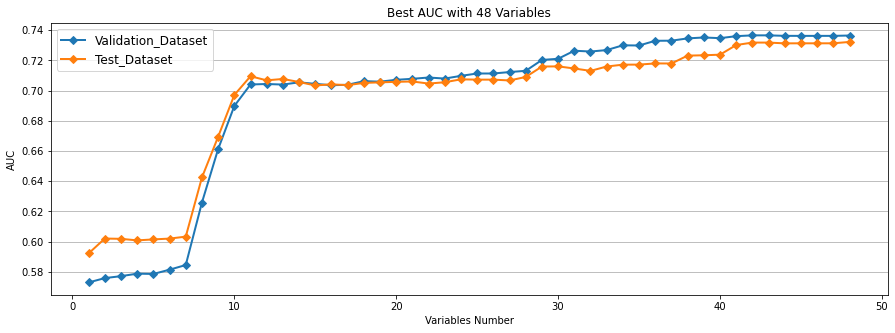

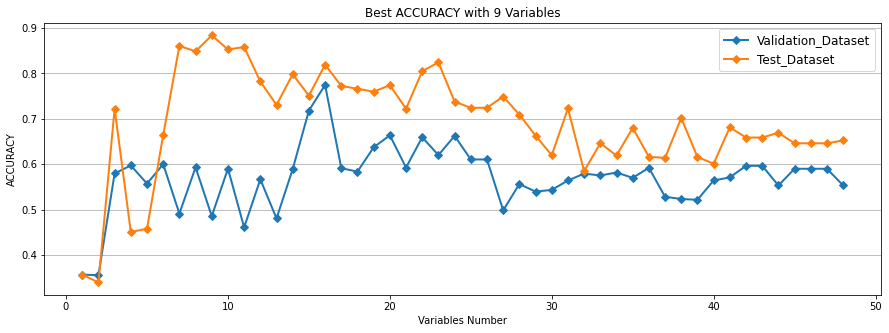

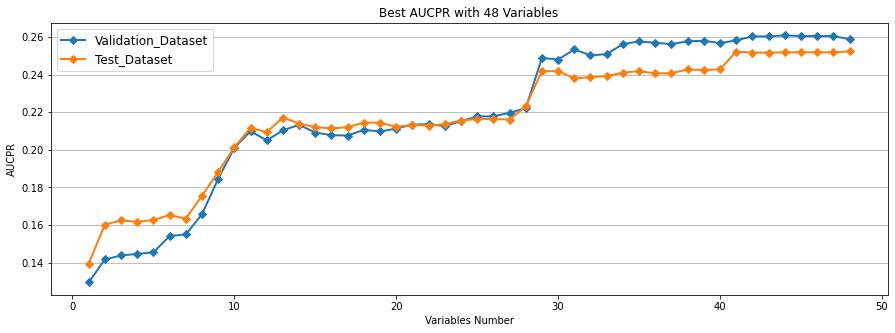

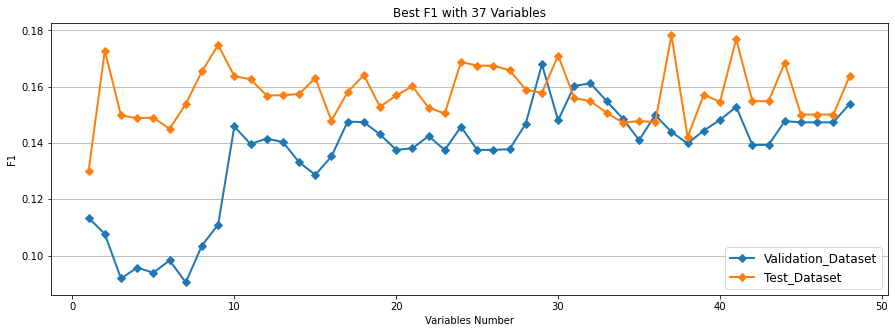

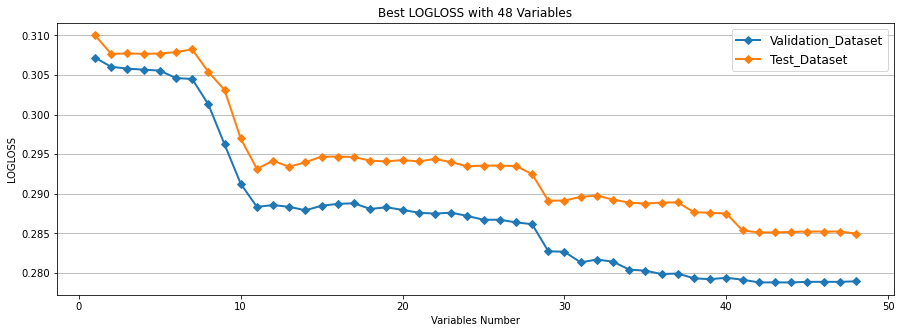

In [59]:
##Plot graph comparing the increase in performance with the increase in variables
for i in dict_performance.keys():
    if i == list(dict_performance.keys())[0]:
        df_performance = dict_performance[i]
    else:
        df_performance = df_performance.append(dict_performance[i], ignore_index=True)

lista_metricas_perf = df_performance['medida'].unique()

for i in range(len(lista_metricas_perf)):   
    #selects only the metric to be analyzed
    metrics_df_tmp = df_performance.query('medida == "%s"' % lista_metricas_perf[i])
    metrics_df_tmp = metrics_df_tmp.set_index('qt_var')
    del metrics_df_tmp['medida']
    if lista_metricas_perf[i] == 'logloss':
        max_oot = metrics_df_tmp[metrics_df_tmp['Test_Dataset'] == metrics_df_tmp.Test_Dataset.min()].index.values
    else:
        max_oot = metrics_df_tmp[metrics_df_tmp['Test_Dataset'] == metrics_df_tmp.Test_Dataset.max()].index.values
        
    if lista_metricas_perf[i] == sort_metric_best_model:
        max_oot_filtro = max_oot[0]        
    
    ax=metrics_df_tmp.plot(figsize=(15,5), linewidth=2, fontsize=10, marker='D', ms=5,\
                            title='Best %s with %s Variables' % (lista_metricas_perf[i].upper(), str(max_oot[0])))
    plt.xlabel('Variables Number')
    plt.ylabel('%s' % lista_metricas_perf[i].upper())
    plt.grid(axis='y')
    plt.legend(loc=0, prop={'size': 12})
    #display(ax)

In [60]:
print('Consider removing the following variables: '+ str(df_features_sorted[df_features_sorted.index > int(max_oot_filtro)].values.tolist()))

TypeError: '>' not supported between instances of 'builtin_function_or_method' and 'int'

In [ ]:
# Consider removing the following variables: ['job_soft_skills_word_count', 'prospect_location_country', 'declared_seniority_to_job']

# 5. Exporting the best model to Deploy

In [29]:
try:
    #Save the H2O model in MOJO format and all the variables of the best model
    melhor_modelo = h2o.load_model('%s/models/candidates/%s' % (OutputPath, modelos_testados.iloc[posicao_melhor_modelo, 0]))
    path_model_mojo = melhor_modelo.download_mojo('%s/models/best/' % OutputPath, get_genmodel_jar=True)
    print('path_model_mojo: ' + str(path_model_mojo))
    caminho_modelo_h2o = h2o.save_model(model=melhor_modelo, path='%s/models/best/' % OutputPath, force=True)
except Exception as e:
    src_path = "%s/models/candidates/%s.py" % (OutputPath, ModelId)
    dst_path = "%s/models/best/%s.py" % (OutputPath, ModelId)
    shutil.copy(src_path, dst_path)
    print('path_sagemaker_model: ' + str(dst_path))

path_model_mojo: D:\OneDrive\INTERA\data-science-lab\model-prop-apply-candidates\output_model\models\best\StackedEnsemble_BestOfFamily_4_AutoML_2_20220907_222845.zip


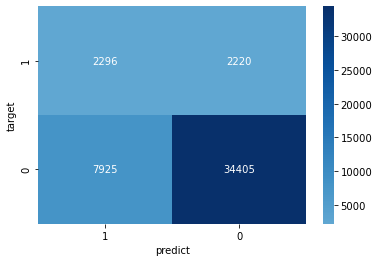

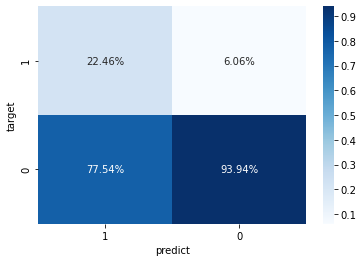

In [30]:
#Confusion Matrix for the Champion
df_predict_tmp = h2o.mojo_predict_pandas(dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])], mojo_zip_path=path_model_mojo, verbose=False)

df_predict = pd.concat([df_predict_tmp.reset_index(drop=True), dataprep_df.query('partition_0 == "test_data"').loc[:, (selected_features+[VarTarget])].reset_index(drop=True)], axis=1)

df_matrix = df_predict.reset_index().groupby([VarTarget, 'predict']).count()[['index']].reset_index().pivot(index=VarTarget, columns='predict', values='index').sort_values(by=[VarTarget], ascending=False).loc[:,(1,0)]

sns.heatmap(df_matrix, annot=True, center=True,cmap='Blues', fmt='g')
plt.show()
sns.heatmap(df_matrix/np.sum(df_matrix), annot=True,
            fmt='.2%', cmap='Blues')
plt.show()

In [74]:
#StackedEnsemble_BestOfFamily_4_AutoML_1_20220713_233617.zip

## 5.1 Cleaning Resources

In [ ]:
sm.delete_endpoint(EndpointName=ep_name)
sm.delete_endpoint_config(EndpointConfigName=epc_name)

# 6. Save final dataset with predictions into S3 to explain the model

In [75]:
csv_buffer = StringIO()
df_predict.to_csv(csv_buffer, index=False, header=True)
s3_resource = my_boto3_session.resource('s3')
s3_resource.Object(bucket, 'databases/%s/%s.csv' % (ModelName+'_scored', ModelName+'_scored')).put(Body=csv_buffer.getvalue())
del csv_buffer

In [76]:
glue = my_boto3_session.client('glue', region_name="us-east-1")

glue.delete_table(
    DatabaseName='datascience',
    Name=ModelName+'_scored'
)

glue.update_crawler(Name='data-science-lab',
                    Targets={'S3Targets': [{'Path': 's3://%s/databases/%s' % (bucket, ModelName+'_scored'),
                               'Exclusions': []}]})

glue.start_crawler(Name='data-science-lab')

{'ResponseMetadata': {'RequestId': 'f8b083c3-d18b-45b0-8825-ba7e752ea7aa',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 08 Sep 2022 02:36:20 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'f8b083c3-d18b-45b0-8825-ba7e752ea7aa'},
  'RetryAttempts': 0}}